In [1]:
import pandas as pd
import glob
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
paths = glob.glob('data_finalized/**/paths.json', recursive=True)
properties = glob.glob('data_finalized/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

In [6]:
df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

df = df.sort_values(by="nodes")

print(f'There are {df.query("pairable & min_permanent < 0").shape[0] / df.query("pairable").shape[0]:.1%} of pairable paths with negative permanents!')

There are 22.0% of pairable paths with negative permanents!


In [10]:
display(df.query("nodes == 10 & edges == 11"))

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
226,junction_52937495,10,11,False,-8,9,"[{'path': [10, 3, 8], 'length': 3, 'pairable':...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",1.234568e-20,5,8,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",3,0,3,0.0,0.0
374,junction_79124920,10,11,True,-8,9,"[{'path': [4, 8, 1, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",3.600000e-01,4,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,3,1,-1.0,1.0
244,junction_55442352,10,11,True,-8,9,"[{'path': [2, 8, 1, 7], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",3.600000e-01,2,7,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,2,2,-1.0,1.0
303,junction_66046404,10,11,False,-8,9,"[{'path': [2, 7, 0], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",1.234568e-20,2,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,0,3,0.0,0.0
61,junction_23159293,10,11,True,-8,9,"[{'path': [2, 6, 0, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}...",8.520710e-01,2,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",2,3,0,1.0,4.0
380,junction_80302251,10,11,True,-8,9,"[{'path': [4, 8, 1, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",3.600000e-01,4,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,3,1,-1.0,1.0
449,junction_96826343,10,11,False,-8,9,"[{'path': [2, 7, 0], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",1.234568e-20,2,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,0,3,0.0,0.0
341,junction_74407648,10,11,True,-8,9,"[{'path': [2, 6, 0, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}...",8.520710e-01,2,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",2,3,0,1.0,4.0
14,junction_12807919,10,11,True,-8,9,"[{'path': [11, 3], 'length': 2, 'pairable': Tr...","[{'length': 2, 'pairable': 1, 'unpairable': 0}...",3.600000e-01,5,10,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",3,3,0,-1.0,1.0
31,junction_16745024,10,11,True,-8,9,"[{'path': [4, 8, 1, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",3.600000e-01,4,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,3,1,-1.0,1.0


In [90]:
def perm(M, max_complexity: int) -> float:
    n = M.shape[0]
    complexity = n * 2**n
    if complexity > max_complexity:
        return -1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]
    return p/2**(n-1)

In [91]:
M = np.array([
    [0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0]
]).astype(np.float64)

# 1) 1 == 2    3 == 4

# 1) 1 -- 2 -- 3 -- 4 -- 1
# 2) 1 == 2    3 == 4
# 3) 2 == 3    4 == 1
# 4) 4 -- 3 -- 2 -- 1 -- 4

# Permanent = number of ways to make loops, ordering conserved


perm(M, 10000)

4.0

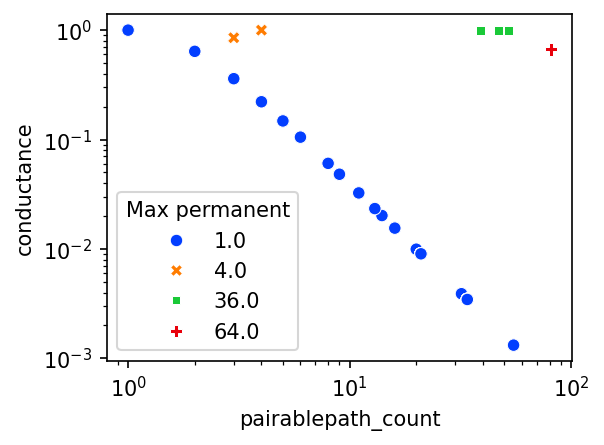

In [15]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.scatterplot(
    data=df.query("pairable & min_permanent >= 0"),
    x="pairablepath_count",
    y="conductance",
    hue="max_permanent",
    palette="bright",
    style="max_permanent",
    ax=ax,
)

# ax.set(xlabel='Number of pairable paths', ylabel='Conductance [$G_0$]')
ax.set_xscale('log')
ax.set_yscale('log')

In [17]:
df.query("nodes == 6")

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
264,junction_58653470,6,6,False,-4,4,"[{'path': [2, 6, 1], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",2.500000e-21,2,5,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",2,0,2,0.0,0.0
411,junction_87572219,6,6,False,-4,4,"[{'path': [5, 0, 4], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",2.500000e-21,1,4,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",2,0,2,0.0,0.0
428,junction_91788365,6,6,True,-4,4,"[{'path': [6, 0], 'length': 2, 'pairable': Tru...","[{'length': 2, 'pairable': 1, 'unpairable': 0}...",6.400000e-01,1,4,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",2,2,0,-1.0,1.0
320,junction_69984564,6,6,False,-4,4,"[{'path': [6, 1, 4], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",2.500000e-21,3,4,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",2,0,2,0.0,0.0
450,junction_96903314,6,6,True,-4,4,"[{'path': [2, 4, 0, 3], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}]",6.400000e-01,2,3,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,2,0,1.0,1.0
28,junction_16218800,6,6,True,-4,4,"[{'path': [2, 4, 0, 3], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}]",6.400000e-01,2,3,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",1,2,0,1.0,1.0
154,junction_39362998,6,6,False,-4,4,"[{'path': [2, 6, 1], 'length': 3, 'pairable': ...","[{'length': 3, 'pairable': 0, 'unpairable': 1}...",2.500000e-21,2,5,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",2,0,2,0.0,0.0
150,junction_38738042,6,6,True,-4,4,"[{'path': [7, 1], 'length': 2, 'pairable': Tru...","[{'length': 2, 'pairable': 1, 'unpairable': 0}...",6.400000e-01,3,6,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",2,2,0,-1.0,1.0
171,junction_42320082,6,6,True,-4,4,"[{'path': [2, 4, 0, 3], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}]",6.400000e-01,2,3,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,2,0,1.0,1.0
